
# Store sales prediction with date and weather

## Import libraries

In [1]:
!pip install --upgrade scikit-learn==1.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 54.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.0 which is incompatible.
bigframes 1.36.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.2.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.0 which is incompatible.


In [2]:
import requests
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

## Data collection

### Download dataset

In [3]:
! gdown --id 10KbcMamNLJlmAtLQ98pls9OngW3k4jG7
! gdown --id 1SRWxGkMqB6adbaoVV9ibLtTErBC2iGgw

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10KbcMamNLJlmAtLQ98pls9OngW3k4jG7
To: /content/weather_mexico_city.csv
100% 471k/471k [00:00<00:00, 67.2MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SRWxGkMqB6adbaoVV9ibLtTErBC2iGgw
To: /content/store_sales.csv
100% 30.2k/30.2k [00:00<00:00, 41.1MB/s]


### Read files

In [4]:
def read_file (filename):
  '''Read csv file and return a dataframe'''
  df = pd.read_csv(filename)
  return df

In [5]:
# Call 'read_file' function to read csv files and return a dataframe
historical_sales = read_file('/content/store_sales.csv')
historical_weather = read_file('/content/weather_mexico_city.csv')

## Initial EDA

### Check data types

In [8]:
historical_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1483 non-null   object 
 1   sales   1483 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.3+ KB


In [9]:
historical_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766 entries, 0 to 1765
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          1766 non-null   object 
 1   tempmax           1766 non-null   float64
 2   tempmin           1766 non-null   float64
 3   temp              1766 non-null   float64
 4   feelslikemax      1766 non-null   float64
 5   feelslikemin      1766 non-null   float64
 6   feelslike         1766 non-null   float64
 7   dew               1766 non-null   float64
 8   humidity          1766 non-null   float64
 9   precip            1766 non-null   float64
 10  precipprob        1766 non-null   int64  
 11  precipcover       1766 non-null   float64
 12  preciptype        1025 non-null   object 
 13  snow              1766 non-null   int64  
 14  snowdepth         1766 non-null   float64
 15  windgust          1766 non-null   float64
 16  windspeed         1766 non-null   float64


### Check for null values

In [18]:
def check_na(df):
  '''Check for null values in a dataframe and print the count'''
  missing_count = df.isnull().sum()
  print(missing_count)
  print('\n')

In [21]:
# Call 'check_na' function to check null values
print('Missing values in historical_weather dataframe:\n')
check_na(historical_weather)
print('Missing values in historical_sales dataframe:\n')
check_na(historical_sales)

Missing values in historical_weather dataframe:

datetime              0
tempmax               0
tempmin               0
temp                  0
feelslikemax          0
feelslikemin          0
feelslike             0
dew                   0
humidity              0
precip                0
precipprob            0
precipcover           0
preciptype          741
snow                  0
snowdepth             0
windgust              0
windspeed             0
winddir               0
sealevelpressure      0
cloudcover            0
visibility            0
solarradiation        0
solarenergy           0
uvindex               0
severerisk          766
sunrise             400
sunset              400
moonphase           400
conditions          400
description         400
icon                400
stations            400
dtype: int64


Missing values in historical_sales dataframe:

date     0
sales    0
dtype: int64




### Summary statistics

In [46]:
print('Summary statistics of historical_weather dataframe:\n')
print(historical_weather.describe())
print('\n')
print('Summary statistics of historical_sales dataframe:\n')
historical_sales.describe()

Summary statistics of historical_weather dataframe:

           tempmax      tempmin        temp  feelslikemax  feelslikemin  \
count  1766.000000  1766.000000  1766.00000   1766.000000   1766.000000   
mean     25.988109     8.710589    17.46846     25.575142      8.383012   
std       3.342014     4.036355     2.55524      2.864947      4.347057   
min      15.400000    -5.900000    10.60000     15.400000    -10.200000   
25%      23.900000     6.000000    15.80000     23.900000      5.100000   
50%      26.000000     9.200000    17.50000     26.000000      9.100000   
75%      28.000000    12.000000    19.10000     27.375000     12.000000   
max      36.500000    18.700000    25.50000     36.300000     18.700000   

            precip  precipcover     windgust    windspeed  
count  1766.000000  1766.000000  1766.000000  1766.000000  
mean      2.276409     5.653364    30.185561    23.968573  
std       5.470510     7.897506    12.767899     7.680819  
min       0.000000     0.000000

,sales
count,1483.000000
mean,35287.786322
std,7341.356719
min,16151.000000
25%,30777.395000
50%,35044.000000
75%,38883.570000
max,87496.370000


## Data Cleaning

### Clean weather data

Keep only importat columns, format column rain

In [22]:
def clean_weather_data(df):
  '''Keep only importat columns, rename date column and preciptype, format is_rain'''
  df = df[['datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'precip', 'precipcover', 'preciptype', 'windgust', 'windspeed']]
  df = df.rename(columns={'datetime': 'date', 'preciptype': 'is_rain'})
  df['is_rain'] = df['is_rain'].fillna('no_rain')
  return df

In [23]:
# Call 'clean_weather_data' on 'historical_weather' dataframe
historical_weather = clean_weather_data(historical_weather)

### Format date column and making it index

In [24]:
def date_to_datetime_index(df):
  '''Convert date column datatype to pandas datetime and make it the index'''
  df['date'] = pd.to_datetime(df['date'], dayfirst=True)
  df = df.set_index('date')
  return df

In [25]:
# Call 'date_to_datetime_index' function to formate 'historical_sales' and 'historical_weather' dataframes
historical_sales = date_to_datetime_index(historical_sales)
historical_weather = date_to_datetime_index(historical_weather)

Merge both dataframes

In [26]:
# Merge dataframes in new dataframe 'data'
data = historical_sales.join(historical_weather, how = 'inner')

Check data on new dataframe

In [27]:
data.head()

,sales,tempmax,tempmin,temp,feelslikemax,feelslikemin,precip,precipcover,is_rain,windgust,windspeed
date,,,,,,,,,,,
2020-10-02,37455.31,19.4,4.7,12.7,19.4,2.7,0.0,0.0,no_rain,34.2,20.5
2020-10-03,37923.31,23.0,5.1,15.1,23.0,2.5,0.0,0.0,no_rain,28.8,16.6
2020-10-04,36265.82,21.1,11.1,15.0,21.1,11.1,0.0,0.0,no_rain,44.3,29.0
2020-10-05,40641.34,24.0,4.1,13.9,24.0,2.2,0.0,0.0,no_rain,31.3,25.8
2020-10-06,39052.39,23.0,5.9,14.6,23.0,5.0,0.0,0.0,no_rain,33.1,22.3


## Data preparation (feature engineering)

### Label Encoding

In [28]:
def add_is_rain(df):
  '''Label encode is_rain column with 1 for rain and 0 for no_rain'''
  df['is_rain'] = df['is_rain'].replace({'rain': 1, 'no_rain': 0})
  return df

### Create date features functions

#### Basic date feature

In [29]:
def add_date_features(df):
  '''Add weekday, week, day, month, year, day_of_year features to dataframe'''
  df['weekday'] = df.index.dayofweek
  df['week'] = df.index.isocalendar().week
  df['day'] = df.index.day
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['day_of_year'] = df.index.dayofyear
  return df

#### Holiday feature

In [30]:
# Create list of holidays
holidays = [
    (1, 6), #Three wisemen Day
    (2, 14), #Valentine's Day
    (9, 15), #Independence Day
    (12, 12), #Virgen de Guadalupe Day
    (12, 24), #Christmas Day
    (12, 31) #New Years Day
]

def add_holidays(df):
  '''
  Add 'is_holiday' feature to dataframe with 'holidays' list of holidays
  '''
  # Serch on index for holidays dates and put 1 for yes and 0 for no
  df['is_holiday'] = df.index.map(
    lambda x: 1 if (x.month, x.day) in holidays else 0)
  return df

#### Sunday feature

In [31]:
def add_sunday(df):
  '''
  Add is_sunday feature to dataframe with 'weekday' column number
  '''
  df['is_sunday'] = (df['weekday'] == 6).astype(int)
  return df

#### Payday feature

In [32]:
def add_payday(df):
  '''
  Add is_payday feature to dataframe getting the 15th and last of the month which are paydays,
  adjusting to the previous Friday if payday is on a weekend and check if index matches a payday
  '''
  # Get the 15th and last day of the month
  fifteenth = df.index.to_period('M').to_timestamp('ms') + pd.offsets.Day(14)
  last_day = df.index.to_period('M').to_timestamp('M')

  # Adjust to the previous Friday if payday is on a weekend
  fifteenth = fifteenth.where(fifteenth.weekday <= 4, fifteenth - pd.offsets.Week(weekday=4))
  last_day = last_day.where(last_day.weekday <= 4, last_day - pd.offsets.Week(weekday=4))

  # Check if the index matches a payday
  df['is_payday'] = ((df.index.isin(fifteenth)) | (df.index.isin(last_day))).astype(int)

  return df

### Create lag features functions

#### Holidays lag feature

In [33]:
# Create list of day lags for holidays
holiday_lags = [1, 2, 3]

def add_holiday_lag(df):
  '''
  Add 'is_holiday_x_lag' features to dataframe with 'holiday_lags' list of lags
  '''
  for lag in holiday_lags:
    df[f'is_holiday_{lag}_lag'] = df['is_holiday'].shift(lag)
  return df

#### Sales lag feature

In [34]:
# Create list of day lags for sales
lags = [1, 7, 14, 28, 364]

def add_lags(df):
  '''
  Add 'sales_lag_x' features to dataframe with 'lags' list of lags
  '''
  for lag in lags:
    df[f'sales_lag_{lag}'] = df['sales'].shift(lag)
  return(df)

### Create rolling averages function

In [35]:
# Create list of rolling windows
rolling_windows = [7, 14, 28, 364]

def add_roll_avg(df):
  '''
  Add 'sales_rolling_avg_x' features to dataframe with 'rolling_windows' list of rolling windows
  '''
  for rolling_window in rolling_windows:
    df[f'sales_rolling_avg_{rolling_window}'] = df['sales'].rolling(window=rolling_window, min_periods=1).mean()
  return(df)

### Add all features

In [36]:
def add_features(df):
  '''
  Call all functions to add features to dataframe
  '''
  df = df.copy()
  df = add_date_features(df)
  df = add_is_rain(df)
  df = add_holidays(df)
  df = add_sunday(df)
  df = add_payday(df)
  df = add_holiday_lag(df)
  df = add_lags(df)
  df = add_roll_avg(df)
  return df

In [37]:
# Add all features to 'data' dataframe
data = add_features(data)

<ipython-input-28-a6233e6d2d21>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_rain'] = df['is_rain'].replace({'rain': 1, 'no_rain': 0})


## Advanced EDA

### Sales trends over time

#### All sales over time

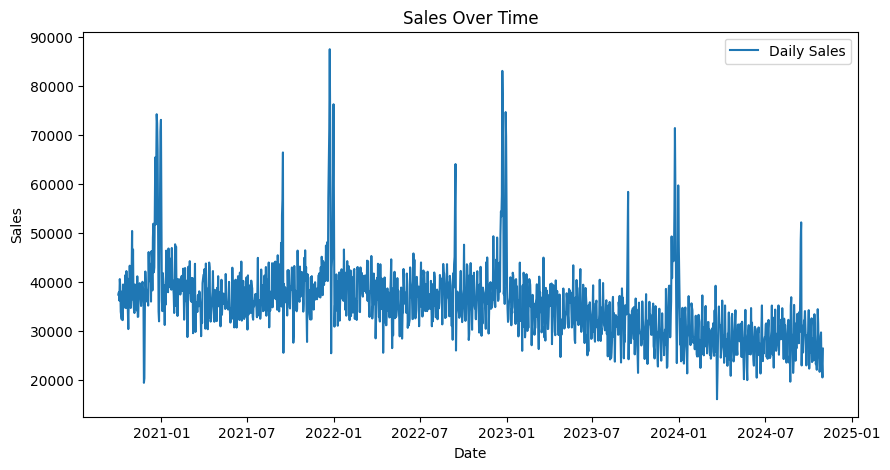

In [48]:
# Plot daily sales
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['sales'], label='Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.legend()
plt.show()

#### Weekly & Monthly Trends

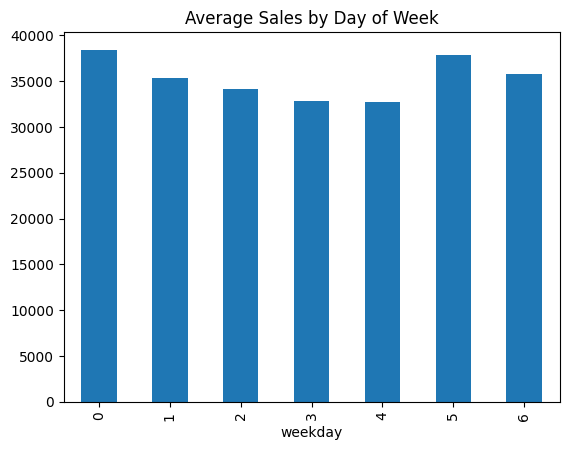

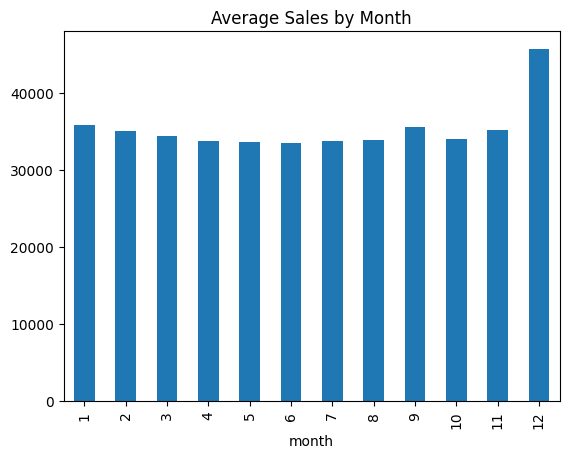

In [55]:
# Average sales by day of the week
data.groupby('weekday')['sales'].mean().plot(kind='bar', title="Average Sales by Day of Week")
plt.show()

# Average sales by month
data.groupby('month')['sales'].mean().plot(kind='bar', title="Average Sales by Month")
plt.show()

### Correlation between sales and weather

In [57]:
data.columns

Index(['sales', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'precip', 'precipcover', 'is_rain', 'windgust', 'windspeed', 'weekday',
       'week', 'day', 'month', 'year', 'day_of_year', 'is_holiday',
       'is_sunday', 'is_payday', 'is_holiday_1_lag', 'is_holiday_2_lag',
       'is_holiday_3_lag', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14',
       'sales_lag_28', 'sales_lag_364', 'sales_rolling_avg_7',
       'sales_rolling_avg_14', 'sales_rolling_avg_28',
       'sales_rolling_avg_364'],
      dtype='object')

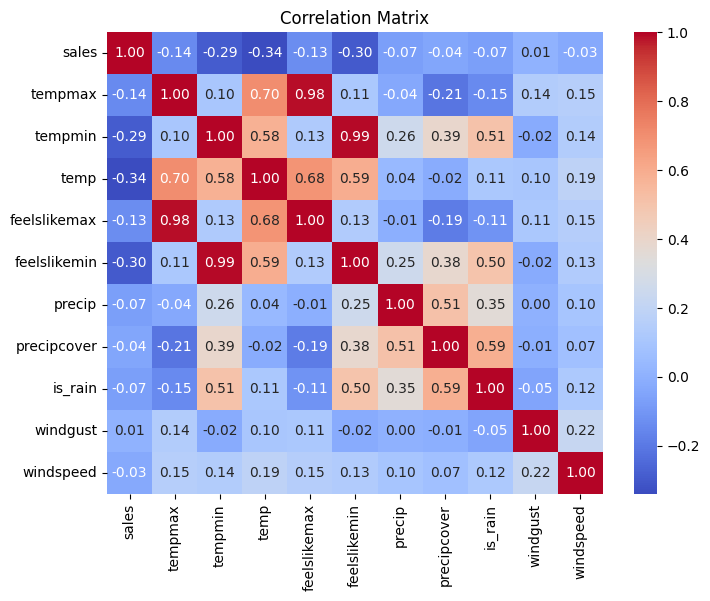

In [58]:
# Select numeric features
corr_df = data[['sales', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'precip', 'precipcover', 'is_rain', 'windgust', 'windspeed']].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Scatter Plots (Sales vs. Weather Features)

<Figure size 500x500 with 0 Axes>

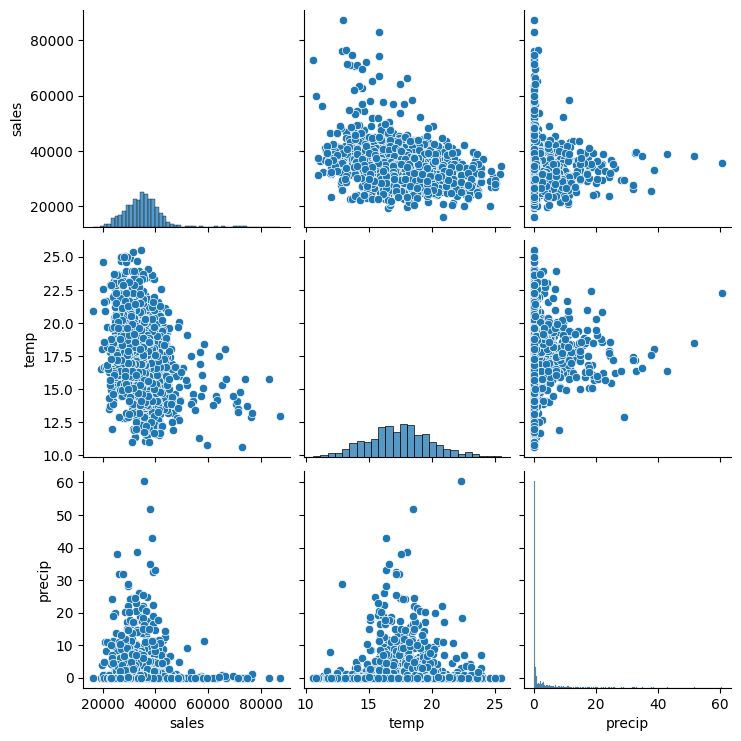

In [64]:
# Plot sales vs weather features scatter plots
plt.title('Sales vs. Weather features')
plt.figure(figsize=(5, 5))
sns.pairplot(data[['sales', 'temp', 'precip']])
plt.show()

### Rolling Sales Trends

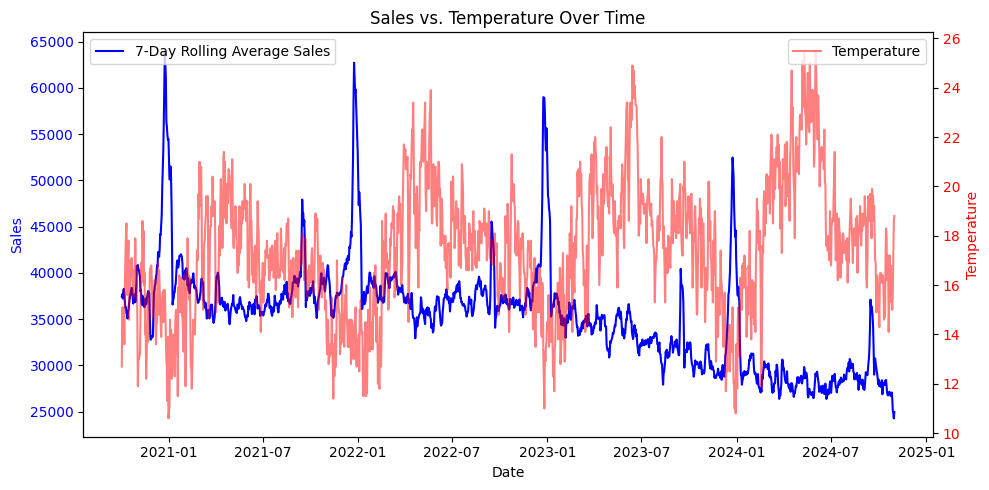

In [72]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot sales on the primary y-axis (ax1)
ax1.plot(data.index, data['sales_rolling_avg_7'], label='7-Day Rolling Average Sales', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis (ax2)
ax2 = ax1.twinx()  # Share the same x-axis

# Plot temperature on the secondary y-axis (ax2)
ax2.plot(data.index, data['temp'], label='Temperature', color='red', alpha=0.5)
ax2.set_ylabel('Temperature', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends for both axes
ax1.legend(loc='upper left')  # Sales legend
ax2.legend(loc='upper right')  # Temperature legend

plt.title('Sales vs. Temperature Over Time')
fig.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


## API

### Set up API for weather data

In [56]:
# Set up variables to create url for API
API_KEY = 'CK35K2LC7AG646872VCECEA7H'
CITY = 'Mexico%20City%2CMexico'
BASE_URL = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/'

### Get 15 days of weather forecast

In [ ]:
def get_weather_forecast(df):
  '''
  Get 15 days of weather forecast from API and add it to dataframe
  '''
  # Create url with 'BASE_URL', 'CITY' and 'API_KEY' variable to connect with API
  url = f"{BASE_URL}{CITY}?unitGroup=metric&include=days&key={API_KEY}&contentType=json"

  # Save request in 'response' variable and format it to .json
  response = requests.get(url)
  API_data = response.json()

  # Convert the ['days'] part of the API response to a dataframe
  df = pd.json_normalize(API_data['days'])

  # Format 'preciptype' column
  df['preciptype'] = df['preciptype'].str[0]
  return df

In [ ]:
# Create new dataframe
fifteen_days_forecast = pd.DataFrame()

# Use function 'get_weather_forecast' to get 15 days of weather forecast from API
fifteen_days_forecast = get_weather_forecast(fifteen_days_forecast)

In [ ]:
# Clean fifteen_days_forecast weather data with function
fifteen_days_forecast = clean_weather_data(fifteen_days_forecast)

In [ ]:
# Check the new dataframe with the weather data from the API
fifteen_days_forecast.head()

,date,tempmax,tempmin,temp,feelslikemax,feelslikemin,precip,precipcover,is_rain,windgust,windspeed
0,2025-02-13,22.4,2.0,16.5,22.4,2.0,0.0,0.00,rain,15.1,20.9
1,2025-02-14,22.0,12.8,17.1,22.0,12.8,0.2,4.17,rain,15.8,13.3
2,2025-02-15,23.8,14.2,18.5,23.8,14.2,0.2,4.17,rain,17.6,19.4
3,2025-02-16,21.9,13.8,17.4,21.9,13.8,0.1,4.17,rain,21.2,20.2
4,2025-02-17,21.5,13.0,15.8,21.5,13.0,0.1,4.17,rain,27.7,25.2


### Get next 15 days of weather data

In [64]:
def get_next_fifteen_days_weather(df):
  '''
  Get the next 15 days of weather data from API
  '''
  # Find the last date of the dataframe
  last_date = df.index.max().strftime('%Y-%m-%d')
  # Add 15 days to last date
  next_date = (pd.to_datetime(last_date) + pd.DateOffset(days=15)).strftime('%Y-%m-%d')

  # Print dates
  print(f'Last date: {last_date}')
  print(f'Next date: {next_date}')

  # Generate url and call API
  url = f"{BASE_URL}{CITY}/{last_date}/{next_date}?unitGroup=metric&include=days&key={API_KEY}&contentType=json"
  response = requests.get(url)
  API_data = response.json()

  # Format new weather data
  new_weather = pd.json_normalize(API_data['days'])
  new_weather['preciptype'] = new_weather['preciptype'].str[0]
  new_weather = clean_weather_data(new_weather)
  new_weather['date'] = pd.to_datetime(new_weather['date'])
  new_weather = new_weather.set_index('date')

  # Create new column 'is_future' in each dataframe to know if it's future data
  df['is_future'] = False
  new_weather['is_future'] = True

  # Merge new weather data with existing data
  original_columns = df.columns
  df = df.combine_first(new_weather)
  df = df.reindex(columns=original_columns)

  # Pring last 15 rows of dataframe
  print('Updated rows:')
  print(df.tail(15))
  return df

### Get weather data for new sales dates

In [ ]:
def get_new_weather(df):
  '''
  Get weather data for new sales dates from API
  '''
  # Find the first and last date with weather missing values
  missing_tempmax = df[df['tempmax'].isna()]
  first_date = missing_tempmax.index.min().strftime('%Y-%m-%d')
  last_date = missing_tempmax.index.max().strftime('%Y-%m-%d')

  # Generate url and call API
  url = f"{BASE_URL}{CITY}/{first_date}/{last_date}?unitGroup=metric&include=days&key={API_KEY}&contentType=json"
  response = requests.get(url)
  API_data = response.json()

  # Format new weather data
  new_weather = pd.json_normalize(API_data['days'])
  new_weather['preciptype'] = new_weather['preciptype'].str[0]
  new_weather = clean_weather_data(new_weather)
  new_weather['date'] = pd.to_datetime(new_weather['date'])
  new_weather = new_weather.set_index('date')
  new_weather = new_weather.loc[missing_tempmax.index]

  # Merge new weather data with existing data
  original_columns = df.columns
  df = df.combine_first(new_weather)
  df = df.reindex(columns=original_columns)
  #df = add_features(df)

  print('Updated rows:')
  print(df.loc[missing_tempmax.index])
  return df

In [ ]:
# Get missing weather data from 'data' dataframe
data = get_new_weather(data)

Updated rows:
              sales  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
date                                                                      
2025-02-08  30000.0     29.0     13.0  18.1          27.5          13.0   
2025-02-11  35000.0     31.0      7.0  17.6          29.2           7.0   
2025-02-12  40000.0     24.0     13.7  18.2          24.0          13.7   

            precip  precipcover  is_rain  windgust  ...  is_holiday_3_lag  \
date                                                ...                     
2025-02-08     0.0         0.00  no_rain      18.0  ...               NaN   
2025-02-11     0.2         4.17     rain      16.6  ...               NaN   
2025-02-12     0.0         0.00  no_rain      17.3  ...               NaN   

            sales_lag_1  sales_lag_7  sales_lag_14  sales_lag_28  \
date                                                               
2025-02-08          NaN          NaN           NaN           NaN   
2025-02-11          

In [ ]:
# Add all features to new data
data = add_features(data)

<ipython-input-125-1974d9385345>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_rain'] = df['is_rain'].replace({'rain': 1, 'no_rain': 0})


In [ ]:
data.tail(15)

,sales,tempmax,tempmin,temp,feelslikemax,feelslikemin,precip,precipcover,is_rain,windgust,...,is_holiday_3_lag,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_28,sales_lag_364,sales_rolling_avg_7,sales_rolling_avg_14,sales_rolling_avg_28,sales_rolling_avg_364
date,,,,,,,,,,,,,,,,,,,,,
2024-10-20,34506.54,16.0,11.6,14.1,16.0,11.6,0.0,0.00,1.0,36.0,...,0.0,26918.05,33477.02,30953.03,31850.37,24351.51,26881.785714,27599.972143,27933.756786,29666.826648
2024-10-21,31521.06,18.5,12.9,15.1,18.5,12.9,2.6,20.83,1.0,28.8,...,0.0,34506.54,29773.98,32647.20,34120.33,30930.48,27131.368571,27519.533571,27840.925714,29668.449121
2024-10-22,25562.69,23.5,13.0,17.2,23.5,13.0,0.0,0.00,1.0,22.7,...,0.0,31521.06,27303.50,23730.70,30924.50,32517.66,26882.681429,27650.390000,27649.432500,29649.342060
2024-10-23,24394.54,24.8,9.4,16.1,24.8,9.4,0.0,0.00,0.0,18.0,...,0.0,25562.69,23283.04,28551.01,27331.51,37571.85,27041.467143,27353.499286,27544.540714,29613.140659
2024-10-24,21735.82,23.3,12.5,16.8,23.3,12.5,0.0,0.00,0.0,17.3,...,0.0,24394.54,24235.01,28438.51,23041.50,28947.82,26684.440000,26874.735714,27497.909286,29593.327473
2024-10-25,22640.04,22.7,4.9,15.3,22.7,4.9,0.0,0.00,0.0,15.8,...,0.0,21735.82,22152.38,24041.64,26540.52,25501.83,26754.105714,26774.621429,27358.606429,29585.465412
2024-10-26,29031.57,22.0,11.4,15.4,22.0,11.4,0.0,0.00,0.0,13.7,...,0.0,22640.04,26918.05,27341.03,29230.03,23342.82,27056.037143,26895.374286,27351.518571,29601.093846
2024-10-27,29765.52,20.0,8.4,15.0,20.0,8.4,0.2,4.17,1.0,16.9,...,0.0,29031.57,34506.54,33477.02,28631.03,26021.33,26378.748571,26630.267143,27392.036071,29611.380082
2024-10-28,22788.26,20.8,11.6,15.7,20.8,11.6,0.0,0.00,1.0,18.0,...,0.0,29765.52,31521.06,29773.98,29930.54,32252.48,25131.205714,26131.287143,27136.954643,29585.379478


## Data Model

### Time Series Cross Validation

In [27]:
# Create Time Series Split to split data for training
tss = TimeSeriesSplit(n_splits=48, test_size=15, gap = 7)

In [28]:
# Check 'tss' variable to verify split
tss

TimeSeriesSplit(gap=7, max_train_size=None, n_splits=48, test_size=15)

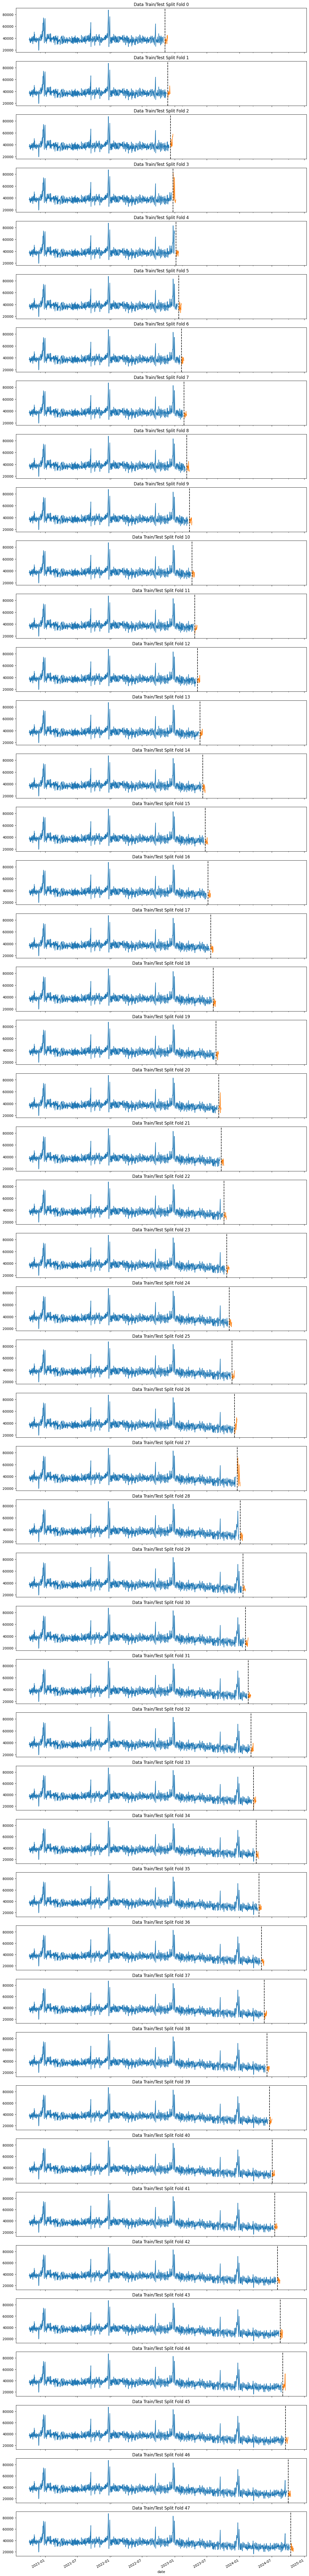

In [29]:
# Plot train/test splits
fig, axs = plt.subplots(48, 1, figsize=(15, 150), sharex = True)

fold = 0
for train_idx, val_idx in tss.split(data):
  train = data.iloc[train_idx]
  test = data.iloc[val_idx]
  train['sales'].plot(ax=axs[fold],
                    label='Training Set',
                    title=f'Data Train/Test Split Fold {fold}')
  test['sales'].plot(ax=axs[fold], label='Test Set')
  axs[fold].axvline(test.index.min(), color='black', ls='--')
  fold += 1

### Train using cross validation

In [78]:
# Split the data for Time Series data
tss = TimeSeriesSplit(n_splits=48, test_size=15, gap = 7)
data = data.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(data):
  train = data.iloc[train_idx]
  test = data.iloc[val_idx]

  train = add_features(train)
  test = add_features(test)

  # Define features and target data
  FEATURES = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'precip',
       'precipcover', 'is_rain', 'windgust', 'windspeed', 'weekday', 'week',
       'day', 'month', 'year', 'day_of_year', 'is_holiday', 'is_sunday',
       'is_payday', 'is_holiday_1_lag', 'is_holiday_2_lag', 'is_holiday_3_lag',
       'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28',
       'sales_lag_364', 'sales_rolling_avg_7', 'sales_rolling_avg_14',
       'sales_rolling_avg_28', 'sales_rolling_avg_364']
  TARGET = 'sales'

  # Create x and y train and test dataset with features and target
  x_train = train[FEATURES]
  y_train = train[TARGET]

  x_test = test[FEATURES]
  y_test = test[TARGET]


  # Tune regressor model
  reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                         n_estimators=500,
                         early_stopping_rounds=50,
                         objective='reg:linear',
                         max_depth=3,
                         learning_rate=0.01)

  # Fit model on train and test sets
  reg.fit(x_train, y_train,
          eval_set=[(x_train, y_train), (x_test, y_test)],
          verbose=100)

  # Predict on test and append score
  y_pred = reg.predict(x_test)
  preds.append(y_pred)
  score = np.sqrt(mean_squared_error(y_test, y_pred))
  scores.append(score)

[0]	validation_0-rmse:38466.44589	validation_1-rmse:36641.13669
[100]	validation_0-rmse:14672.40112	validation_1-rmse:14069.34485


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:26:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6248.43321	validation_1-rmse:6325.83593
[300]	validation_0-rmse:3654.30982	validation_1-rmse:4053.46899
[400]	validation_0-rmse:2978.59743	validation_1-rmse:3406.73749
[499]	validation_0-rmse:2755.80561	validation_1-rmse:3156.99017
[0]	validation_0-rmse:38420.15668	validation_1-rmse:37454.89419
[100]	validation_0-rmse:14647.05806	validation_1-rmse:14594.85592


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:26:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6226.31153	validation_1-rmse:6470.94099
[300]	validation_0-rmse:3621.94735	validation_1-rmse:4239.64734
[400]	validation_0-rmse:2954.57963	validation_1-rmse:3820.21037
[499]	validation_0-rmse:2730.62428	validation_1-rmse:3769.68350
[0]	validation_0-rmse:38393.42342	validation_1-rmse:44195.36120
[100]	validation_0-rmse:14634.03203	validation_1-rmse:18327.71551


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:26:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6225.44315	validation_1-rmse:8690.69083
[300]	validation_0-rmse:3645.89855	validation_1-rmse:5792.62049
[400]	validation_0-rmse:2984.40419	validation_1-rmse:4962.06748
[499]	validation_0-rmse:2750.72325	validation_1-rmse:4673.25489
[0]	validation_0-rmse:38413.56080	validation_1-rmse:50097.49326
[100]	validation_0-rmse:14645.17008	validation_1-rmse:26684.37744


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:26:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6230.59017	validation_1-rmse:19023.04939
[300]	validation_0-rmse:3669.17807	validation_1-rmse:16494.77214
[400]	validation_0-rmse:3014.68323	validation_1-rmse:15444.63323
[499]	validation_0-rmse:2791.31645	validation_1-rmse:15102.03647
[0]	validation_0-rmse:38775.56979	validation_1-rmse:37111.89256
[100]	validation_0-rmse:14811.41376	validation_1-rmse:13963.40223


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:26:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6337.64573	validation_1-rmse:5787.85247
[300]	validation_0-rmse:3735.59355	validation_1-rmse:3169.73218
[400]	validation_0-rmse:3055.85518	validation_1-rmse:2638.70248
[499]	validation_0-rmse:2858.81531	validation_1-rmse:2565.94040
[0]	validation_0-rmse:38733.54960	validation_1-rmse:34740.06357


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:14802.90519	validation_1-rmse:12972.13064
[200]	validation_0-rmse:6344.61970	validation_1-rmse:6047.74219
[300]	validation_0-rmse:3735.59626	validation_1-rmse:4564.18535
[400]	validation_0-rmse:3046.60179	validation_1-rmse:4434.97365
[417]	validation_0-rmse:2993.74373	validation_1-rmse:4430.70724
[0]	validation_0-rmse:38676.83336	validation_1-rmse:35806.22611
[100]	validation_0-rmse:14780.40791	validation_1-rmse:13706.96448


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6353.84333	validation_1-rmse:6107.83590
[300]	validation_0-rmse:3759.14877	validation_1-rmse:3870.05055
[400]	validation_0-rmse:3076.77771	validation_1-rmse:3331.30182
[499]	validation_0-rmse:2874.71641	validation_1-rmse:3198.32773
[0]	validation_0-rmse:38616.89944	validation_1-rmse:33483.27382
[100]	validation_0-rmse:14759.36253	validation_1-rmse:11589.73833


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6343.31147	validation_1-rmse:4142.22429
[300]	validation_0-rmse:3753.44377	validation_1-rmse:2579.71050
[374]	validation_0-rmse:3177.61823	validation_1-rmse:2569.54540
[0]	validation_0-rmse:38553.34895	validation_1-rmse:34253.57706
[100]	validation_0-rmse:14727.80423	validation_1-rmse:12533.84699


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6327.88494	validation_1-rmse:5588.95369
[300]	validation_0-rmse:3744.25916	validation_1-rmse:4187.47263
[400]	validation_0-rmse:3071.00098	validation_1-rmse:4000.79270
[499]	validation_0-rmse:2856.45727	validation_1-rmse:3909.18562
[0]	validation_0-rmse:38485.48189	validation_1-rmse:34645.68329
[100]	validation_0-rmse:14709.09889	validation_1-rmse:12457.73315


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6326.39772	validation_1-rmse:4908.82255
[300]	validation_0-rmse:3749.94204	validation_1-rmse:3120.20324
[400]	validation_0-rmse:3078.88126	validation_1-rmse:2963.99784
[422]	validation_0-rmse:3011.94156	validation_1-rmse:2970.93294
[0]	validation_0-rmse:38421.12559	validation_1-rmse:34653.04758


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:14679.01024	validation_1-rmse:12712.70052
[200]	validation_0-rmse:6303.63069	validation_1-rmse:5086.35718
[300]	validation_0-rmse:3729.93162	validation_1-rmse:3233.33001
[400]	validation_0-rmse:3063.65566	validation_1-rmse:2930.75894
[499]	validation_0-rmse:2855.69198	validation_1-rmse:2883.26591
[0]	validation_0-rmse:38369.20406	validation_1-rmse:32376.69397


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:14655.91653	validation_1-rmse:10773.21267
[200]	validation_0-rmse:6287.21268	validation_1-rmse:3593.08807
[300]	validation_0-rmse:3714.22242	validation_1-rmse:2795.92751
[330]	validation_0-rmse:3416.81354	validation_1-rmse:2885.90981
[0]	validation_0-rmse:38286.84148	validation_1-rmse:35246.28042
[100]	validation_0-rmse:14629.73841	validation_1-rmse:13240.60909


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6289.22660	validation_1-rmse:5514.77513
[300]	validation_0-rmse:3741.92165	validation_1-rmse:3295.10568
[400]	validation_0-rmse:3093.24832	validation_1-rmse:2857.67399
[499]	validation_0-rmse:2895.67279	validation_1-rmse:2757.67081
[0]	validation_0-rmse:38227.09140	validation_1-rmse:34749.75100
[100]	validation_0-rmse:14600.13819	validation_1-rmse:13251.10304


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6269.61009	validation_1-rmse:5856.54882
[300]	validation_0-rmse:3717.50820	validation_1-rmse:3781.06578
[400]	validation_0-rmse:3062.74450	validation_1-rmse:3364.82571
[499]	validation_0-rmse:2879.63543	validation_1-rmse:3252.09374
[0]	validation_0-rmse:38167.44344	validation_1-rmse:32785.54758
[100]	validation_0-rmse:14575.26230	validation_1-rmse:11505.74846


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6248.93457	validation_1-rmse:4478.64235
[300]	validation_0-rmse:3706.03657	validation_1-rmse:3216.20468
[400]	validation_0-rmse:3053.27185	validation_1-rmse:3140.12467
[499]	validation_0-rmse:2866.36728	validation_1-rmse:3093.70515
[0]	validation_0-rmse:38111.27275	validation_1-rmse:31701.91202
[100]	validation_0-rmse:14547.20622	validation_1-rmse:10554.28868


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6251.37305	validation_1-rmse:3561.81932
[300]	validation_0-rmse:3714.97022	validation_1-rmse:2707.12511
[336]	validation_0-rmse:3380.48054	validation_1-rmse:2890.90712
[0]	validation_0-rmse:38031.04579	validation_1-rmse:32679.81023
[100]	validation_0-rmse:14516.98034	validation_1-rmse:11506.58216


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6233.65020	validation_1-rmse:4073.57690
[300]	validation_0-rmse:3717.65411	validation_1-rmse:2456.32054
[380]	validation_0-rmse:3147.89065	validation_1-rmse:2404.88829
[0]	validation_0-rmse:37952.07769	validation_1-rmse:32301.42496
[100]	validation_0-rmse:14491.20828	validation_1-rmse:11135.95049


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6227.41500	validation_1-rmse:3996.04563
[300]	validation_0-rmse:3721.41640	validation_1-rmse:2851.95899
[359]	validation_0-rmse:3244.96501	validation_1-rmse:2887.54956
[0]	validation_0-rmse:37885.76718	validation_1-rmse:30392.23761
[100]	validation_0-rmse:14462.08551	validation_1-rmse:9514.53176


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6211.17366	validation_1-rmse:3827.44533
[270]	validation_0-rmse:4146.89223	validation_1-rmse:3942.68409
[0]	validation_0-rmse:37791.59052	validation_1-rmse:32576.76378
[100]	validation_0-rmse:14432.22292	validation_1-rmse:11680.01023


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6211.30084	validation_1-rmse:4651.33005
[300]	validation_0-rmse:3719.04944	validation_1-rmse:3165.47111
[400]	validation_0-rmse:3076.00226	validation_1-rmse:2922.34932
[450]	validation_0-rmse:2961.30074	validation_1-rmse:2975.14032
[0]	validation_0-rmse:37711.51145	validation_1-rmse:35092.15297
[100]	validation_0-rmse:14408.22624	validation_1-rmse:14679.50767


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6208.97878	validation_1-rmse:8860.53291
[300]	validation_0-rmse:3731.65121	validation_1-rmse:7901.01167
[400]	validation_0-rmse:3095.07700	validation_1-rmse:7729.12320
[499]	validation_0-rmse:2897.20499	validation_1-rmse:7638.28460
[0]	validation_0-rmse:37641.91085	validation_1-rmse:31312.85272
[100]	validation_0-rmse:14383.24172	validation_1-rmse:10348.28745


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6197.38884	validation_1-rmse:3796.83635
[300]	validation_0-rmse:3728.57386	validation_1-rmse:3183.67642
[332]	validation_0-rmse:3429.16949	validation_1-rmse:3213.84329
[0]	validation_0-rmse:37605.26586	validation_1-rmse:29416.22696
[100]	validation_0-rmse:14378.78669	validation_1-rmse:8505.14834


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6221.49588	validation_1-rmse:3241.67932
[246]	validation_0-rmse:4686.38171	validation_1-rmse:3554.63395
[0]	validation_0-rmse:37513.17950	validation_1-rmse:30750.63150
[100]	validation_0-rmse:14342.44349	validation_1-rmse:9882.54632


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6210.96265	validation_1-rmse:3838.76484
[300]	validation_0-rmse:3754.92362	validation_1-rmse:3554.02596
[312]	validation_0-rmse:3628.99806	validation_1-rmse:3580.12156
[0]	validation_0-rmse:37418.34584	validation_1-rmse:29477.65686


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:14313.19127	validation_1-rmse:8772.42035
[200]	validation_0-rmse:6213.09197	validation_1-rmse:3531.70198
[261]	validation_0-rmse:4360.22496	validation_1-rmse:3681.55048
[0]	validation_0-rmse:37341.50983	validation_1-rmse:29557.43570
[100]	validation_0-rmse:14277.74147	validation_1-rmse:8842.79946


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6194.33211	validation_1-rmse:3444.34554
[255]	validation_0-rmse:4473.27082	validation_1-rmse:3734.60758
[0]	validation_0-rmse:37245.31591	validation_1-rmse:36339.10305
[100]	validation_0-rmse:14238.24774	validation_1-rmse:13476.14485


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6170.81208	validation_1-rmse:7069.24456
[300]	validation_0-rmse:3737.29368	validation_1-rmse:5870.23290
[400]	validation_0-rmse:3129.95940	validation_1-rmse:5722.05587
[499]	validation_0-rmse:2945.46177	validation_1-rmse:5547.29064
[0]	validation_0-rmse:37173.09593	validation_1-rmse:43403.62524
[100]	validation_0-rmse:14212.41269	validation_1-rmse:15892.07703


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6172.86703	validation_1-rmse:9585.93582
[300]	validation_0-rmse:3772.96487	validation_1-rmse:9292.20848
[317]	validation_0-rmse:3608.94200	validation_1-rmse:9319.94417
[0]	validation_0-rmse:37269.20011	validation_1-rmse:28969.13823
[100]	validation_0-rmse:14246.86681	validation_1-rmse:8528.04192


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6195.83440	validation_1-rmse:3922.09915
[251]	validation_0-rmse:4571.48839	validation_1-rmse:4184.94707
[0]	validation_0-rmse:37229.30962	validation_1-rmse:30307.45654
[100]	validation_0-rmse:14250.88751	validation_1-rmse:9482.23965


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6224.25744	validation_1-rmse:2977.83057
[300]	validation_0-rmse:3834.68066	validation_1-rmse:2620.81808
[310]	validation_0-rmse:3730.87624	validation_1-rmse:2657.56144
[0]	validation_0-rmse:37151.29398	validation_1-rmse:28700.80777


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:14225.91820	validation_1-rmse:8791.19392
[200]	validation_0-rmse:6215.13020	validation_1-rmse:3855.12663
[274]	validation_0-rmse:4169.59483	validation_1-rmse:3867.46267
[0]	validation_0-rmse:37059.39240	validation_1-rmse:29219.26349


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:14194.45038	validation_1-rmse:9047.09413
[200]	validation_0-rmse:6207.91832	validation_1-rmse:3059.98146
[299]	validation_0-rmse:3846.39039	validation_1-rmse:2798.01135
[0]	validation_0-rmse:36974.27696	validation_1-rmse:28351.79089
[100]	validation_0-rmse:14162.37613	validation_1-rmse:8730.44287


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6208.19860	validation_1-rmse:4069.63770
[287]	validation_0-rmse:3984.12129	validation_1-rmse:4084.24587
[0]	validation_0-rmse:36882.08533	validation_1-rmse:28437.02312
[100]	validation_0-rmse:14129.39776	validation_1-rmse:9101.45582


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6197.57451	validation_1-rmse:4790.19714
[275]	validation_0-rmse:4159.86324	validation_1-rmse:4868.68752
[0]	validation_0-rmse:36798.76324	validation_1-rmse:26971.68439
[100]	validation_0-rmse:14102.05264	validation_1-rmse:7337.41761


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6189.20614	validation_1-rmse:3382.44975
[239]	validation_0-rmse:4890.45491	validation_1-rmse:3665.30109
[0]	validation_0-rmse:36703.79572	validation_1-rmse:28473.67728


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:14064.42018	validation_1-rmse:8576.27616
[200]	validation_0-rmse:6180.57404	validation_1-rmse:3170.76224
[281]	validation_0-rmse:4074.17595	validation_1-rmse:3168.15055
[0]	validation_0-rmse:36612.55303	validation_1-rmse:27919.45543
[100]	validation_0-rmse:14025.12591	validation_1-rmse:7948.09732


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6154.77754	validation_1-rmse:2692.12441
[256]	validation_0-rmse:4476.35215	validation_1-rmse:3063.41850
[0]	validation_0-rmse:36532.18461	validation_1-rmse:28187.43383
[100]	validation_0-rmse:13994.11132	validation_1-rmse:8402.88990


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6148.99855	validation_1-rmse:3721.88527
[261]	validation_0-rmse:4372.28210	validation_1-rmse:3928.11987
[0]	validation_0-rmse:36442.04918	validation_1-rmse:27199.09940
[100]	validation_0-rmse:13967.39753	validation_1-rmse:7570.32713


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6133.40962	validation_1-rmse:2931.77127
[242]	validation_0-rmse:4766.54797	validation_1-rmse:3283.63765
[0]	validation_0-rmse:36360.11858	validation_1-rmse:27708.63948
[100]	validation_0-rmse:13938.91253	validation_1-rmse:8213.98258


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6129.88108	validation_1-rmse:3414.53619
[257]	validation_0-rmse:4446.08574	validation_1-rmse:3632.73910
[0]	validation_0-rmse:36269.03738	validation_1-rmse:27634.55468
[100]	validation_0-rmse:13907.02696	validation_1-rmse:7891.43672


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6108.02046	validation_1-rmse:2873.64526
[249]	validation_0-rmse:4592.36973	validation_1-rmse:3184.79411
[0]	validation_0-rmse:36187.41468	validation_1-rmse:28782.43598


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:13878.16251	validation_1-rmse:8716.94826
[200]	validation_0-rmse:6109.10627	validation_1-rmse:3158.13747
[274]	validation_0-rmse:4131.76150	validation_1-rmse:3201.21872
[0]	validation_0-rmse:36110.62723	validation_1-rmse:29176.82748
[100]	validation_0-rmse:13853.14104	validation_1-rmse:8880.75379


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6095.00825	validation_1-rmse:2734.08656
[280]	validation_0-rmse:4030.90713	validation_1-rmse:2838.77564
[0]	validation_0-rmse:36048.58433	validation_1-rmse:28559.09014
[100]	validation_0-rmse:13821.51025	validation_1-rmse:8997.32347


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6091.88043	validation_1-rmse:4744.31077
[262]	validation_0-rmse:4321.27150	validation_1-rmse:4912.22395
[0]	validation_0-rmse:35981.01186	validation_1-rmse:33068.85152
[100]	validation_0-rmse:13796.09378	validation_1-rmse:13537.60736


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6083.07626	validation_1-rmse:8333.92079
[300]	validation_0-rmse:3781.07844	validation_1-rmse:7521.89932
[400]	validation_0-rmse:3203.84382	validation_1-rmse:7235.07042
[499]	validation_0-rmse:3028.08078	validation_1-rmse:7135.04266
[0]	validation_0-rmse:35909.66428	validation_1-rmse:29421.79430
[100]	validation_0-rmse:13775.90738	validation_1-rmse:9271.58538


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6075.46025	validation_1-rmse:3101.73054
[300]	validation_0-rmse:3779.83295	validation_1-rmse:2829.57115
[303]	validation_0-rmse:3745.99956	validation_1-rmse:2844.15865
[0]	validation_0-rmse:35887.35243	validation_1-rmse:27219.73731
[100]	validation_0-rmse:13775.27030	validation_1-rmse:7465.52005


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6091.93904	validation_1-rmse:3148.16914
[238]	validation_0-rmse:4855.24070	validation_1-rmse:3541.91984
[0]	validation_0-rmse:35812.26579	validation_1-rmse:25673.28506


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:27:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:13750.37515	validation_1-rmse:6435.19305
[200]	validation_0-rmse:6088.12155	validation_1-rmse:4123.45221
[211]	validation_0-rmse:5668.93843	validation_1-rmse:4345.71962


In [79]:
# Pring score from training folds
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3856.7289
Fold scores:[3156.9899534435863, 3762.510271629785, 4673.254644787837, 15102.037040173595, 2564.879066480599, 4402.89067419914, 3198.3275809990914, 2515.8861565738935, 3908.9958569001383, 2942.7813219495374, 2881.4485701147423, 2767.9250231294877, 2757.671050401915, 3252.093928779167, 3090.5823208944225, 2665.6844325110364, 2381.8332621033333, 2843.368844525578, 3760.7638749140933, 2919.87394670268, 7638.284548215433, 3161.95086575239, 3237.4262106885826, 3509.6705488359257, 3504.4444032336764, 3431.3801331013674, 5547.290199311082, 9258.138250330521, 3918.8642347372956, 2543.3211239806615, 3760.78120579358, 2700.093227795862, 3903.8518747545263, 4724.10616496042, 3363.6993126024677, 3036.0518153856847, 2686.3794425246506, 3694.6284753655445, 2921.365171334981, 3401.63031121172, 2873.645043507347, 3030.646065333855, 2544.9329632583826, 4720.667528957161, 7132.6987234033995, 2655.6804447880904, 3088.759530469567, 3582.803595635561]


### Feature Importance

In [81]:
# Create table with feature importance
fi_table = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance']).sort_values('importance', ascending = False)

fi_table

,importance
day_of_year,0.188143
sales_rolling_avg_7,0.175435
week,0.135349
is_holiday_1_lag,0.084327
sales_lag_7,0.077648
sales_lag_14,0.057599
sales_lag_1,0.056228
sales_lag_364,0.038999
sales_lag_28,0.037043
sales_rolling_avg_364,0.031430


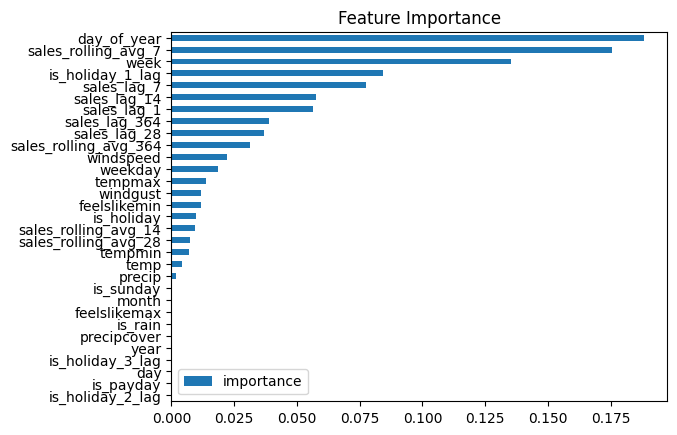

In [82]:
# Plot feature importance table
fi_table.sort_values('importance', ascending = True).plot(kind='barh', title='Feature Importance', )
plt.show()

### Retrain on all data

In [88]:
# Add all features to data dataframe and sort by index
data = add_features(data)
data = data.sort_index()

# Define features and target data
FEATURES = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'precip',
       'precipcover', 'is_rain', 'windgust', 'windspeed', 'weekday', 'week',
       'day', 'month', 'year', 'day_of_year', 'is_holiday', 'is_sunday',
       'is_payday', 'is_holiday_1_lag', 'is_holiday_2_lag', 'is_holiday_3_lag',
       'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28',
       'sales_lag_364', 'sales_rolling_avg_7', 'sales_rolling_avg_14',
       'sales_rolling_avg_28', 'sales_rolling_avg_364']
TARGET = 'sales'

# Create x and y variables with features and target
x_all = data[FEATURES]
y_all = data[TARGET]

# Tune model
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)


In [90]:
# Fit model with all data
reg.fit(x_all, y_all,
        eval_set=[(x_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:35690.10739


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:31:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:13704.15495
[200]	validation_0-rmse:6071.19283
[300]	validation_0-rmse:3807.40886
[400]	validation_0-rmse:3229.73084
[499]	validation_0-rmse:3047.52308


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### Predict the future

In [83]:
# Create a copy of 'data' dataframe
data_and_future = data.copy()

# Call API function to add the next 15 days of weather data
data_and_future = get_next_fifteen_days_weather(data_and_future)

# Add all features to 'data_and_future' dataframe
data_and_future = add_features(data_and_future)

Last date: 2024-10-31
Next date: 2024-11-15
Updated rows:
            sales  tempmax  tempmin  temp  feelslikemax  feelslikemin  precip  \
date                                                                            
2024-11-01    NaN     23.9     13.3  18.3          23.9          13.3     0.0   
2024-11-02    NaN     24.3     10.9  17.5          24.3          10.9     0.6   
2024-11-03    NaN     24.0     12.0  17.8          24.0          12.0     1.9   
2024-11-04    NaN     26.0     12.8  18.1          26.0          12.8     0.4   
2024-11-05    NaN     25.6     12.7  18.4          25.6          12.7     0.0   
2024-11-06    NaN     25.6     10.7  18.4          25.6          10.7     0.0   
2024-11-07    NaN     25.3     13.3  19.5          25.3          13.3     0.0   
2024-11-08    NaN     25.9     12.1  19.5          25.9          12.1     0.0   
2024-11-09    NaN     26.7     11.0  18.9          26.0          11.0     0.0   
2024-11-10    NaN     26.7      8.2  18.1          

<ipython-input-17-a6233e6d2d21>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_rain'] = df['is_rain'].replace({'rain': 1, 'no_rain': 0})


In [77]:
# Verify new weather data in dataframe
data_and_future.tail(20)

,sales,tempmax,tempmin,temp,feelslikemax,feelslikemin,precip,precipcover,is_rain,windgust,windspeed,weekday,week,day,month,year,day_of_year,is_holiday,is_sunday,is_payday,is_holiday_1_lag,is_holiday_2_lag,is_holiday_3_lag,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_28,sales_lag_364,sales_rolling_avg_7,sales_rolling_avg_14,sales_rolling_avg_28,sales_rolling_avg_364,prediction_x,prediction_y,is_future
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-27,29765.52,20.0,8.4,15.0,20.0,8.4,0.2,4.17,1.0,16.9,25.9,6,43,27,10,2024,301,0,1,0,0.0,0.0,0.0,29031.57,34506.54,33477.02,28631.03,26021.33,26378.748571,26630.267143,27392.036071,29611.380082,25328.542969,25328.542969,False
2024-10-28,22788.26,20.8,11.6,15.7,20.8,11.6,0.0,0.00,1.0,18.0,25.9,0,44,28,10,2024,302,0,0,0,0.0,0.0,0.0,29765.52,31521.06,29773.98,29930.54,32252.48,25131.205714,26131.287143,27136.954643,29585.379478,25098.666016,25098.666016,False
2024-10-29,23283.54,23.7,10.6,17.3,23.7,10.6,0.0,0.00,1.0,21.6,13.0,1,44,29,10,2024,303,0,0,0,0.0,0.0,0.0,22788.26,25562.69,27303.50,34308.02,31666.16,24805.612857,25844.147143,26743.223214,29562.350302,24112.988281,24112.988281,False
2024-10-30,20590.85,24.7,11.6,18.6,24.7,11.6,4.8,4.17,1.0,18.0,15.8,2,44,30,10,2024,304,0,0,0,0.0,0.0,0.0,23283.54,24394.54,23283.04,22391.51,36009.66,24262.228571,25651.847857,26678.913929,29519.990934,24112.988281,24112.988281,False
2024-10-31,26466.05,24.1,12.1,18.8,24.1,12.1,0.0,0.00,1.0,19.8,23.6,3,44,31,10,2024,305,0,0,1,0.0,0.0,0.0,20590.85,21735.82,24235.01,25966.48,31430.35,24937.975714,25811.207857,26696.755714,29506.352747,22517.691406,22517.691406,False
2024-11-01,NaN,23.9,13.3,18.3,23.9,13.3,0.0,0.00,0.0,28.4,18.3,4,44,1,11,2024,306,0,0,0,0.0,0.0,0.0,26466.05,22640.04,22152.38,25648.07,33387.86,25320.965000,26092.656154,26735.595926,29495.659890,NaN,NaN,True
2024-11-02,NaN,24.3,10.9,17.5,24.3,10.9,0.6,4.17,1.0,18.7,14.8,5,44,2,11,2024,307,0,0,0,0.0,0.0,0.0,NaN,29031.57,26918.05,26728.51,30845.52,24578.844000,26023.873333,26735.868462,29491.930994,NaN,NaN,True
2024-11-03,NaN,24.0,12.0,17.8,24.0,12.0,1.9,12.50,1.0,18.0,25.8,6,44,3,11,2024,308,0,1,0,0.0,0.0,0.0,NaN,29765.52,34506.54,30953.03,29277.38,23282.175000,25252.721818,26567.182000,29492.525319,NaN,NaN,True
2024-11-04,NaN,26.0,12.8,18.1,26.0,12.8,0.4,12.50,1.0,22.3,20.1,0,45,4,11,2024,309,0,0,0,0.0,0.0,0.0,NaN,22788.26,31521.06,32647.20,33109.52,23446.813333,24625.888000,26313.847917,29482.478111,NaN,NaN,True


In [84]:
# Create a copy of the dataframe with only the future values
future_w_features = data_and_future.query('is_future').copy()

In [70]:
# Verify data in copy with future data
future_w_features.head()

,sales,tempmax,tempmin,temp,feelslikemax,feelslikemin,precip,precipcover,is_rain,windgust,windspeed,weekday,week,day,month,year,day_of_year,is_holiday,is_sunday,is_payday,is_holiday_1_lag,is_holiday_2_lag,is_holiday_3_lag,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_28,sales_lag_364,sales_rolling_avg_7,sales_rolling_avg_14,sales_rolling_avg_28,sales_rolling_avg_364,prediction_x,prediction_y,is_future
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-01,NaN,23.9,13.3,18.3,23.9,13.3,0.0,0.00,0.0,28.4,18.3,4,44,1,11,2024,306,0,0,0,0.0,0.0,0.0,26466.05,22640.04,22152.38,25648.07,33387.86,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-11-02,NaN,24.3,10.9,17.5,24.3,10.9,0.6,4.17,1.0,18.7,14.8,5,44,2,11,2024,307,0,0,0,0.0,0.0,0.0,NaN,29031.57,26918.05,26728.51,30845.52,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-11-03,NaN,24.0,12.0,17.8,24.0,12.0,1.9,12.50,1.0,18.0,25.8,6,44,3,11,2024,308,0,1,0,0.0,0.0,0.0,NaN,29765.52,34506.54,30953.03,29277.38,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-11-04,NaN,26.0,12.8,18.1,26.0,12.8,0.4,12.50,1.0,22.3,20.1,0,45,4,11,2024,309,0,0,0,0.0,0.0,0.0,NaN,22788.26,31521.06,32647.20,33109.52,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-11-05,NaN,25.6,12.7,18.4,25.6,12.7,0.0,0.00,0.0,19.1,20.7,1,45,5,11,2024,310,0,0,0,0.0,0.0,0.0,NaN,23283.54,25562.69,23730.70,29374.64,NaN,NaN,NaN,NaN,NaN,NaN,True


In [91]:
# Predict next 15 days
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [92]:
# Print predictions
print(future_w_features['pred'])

date
2024-11-01    24664.759766
2024-11-02    28229.181641
2024-11-03    29601.912109
2024-11-04    27749.236328
2024-11-05    25908.937500
2024-11-06    25914.683594
2024-11-07    36154.593750
2024-11-08    39353.039062
2024-11-09    40823.332031
2024-11-10    39918.609375
2024-11-11    40483.773438
2024-11-12    39630.859375
2024-11-13    39353.039062
2024-11-14    39199.648438
2024-11-15    39869.945312
Name: pred, dtype: float32


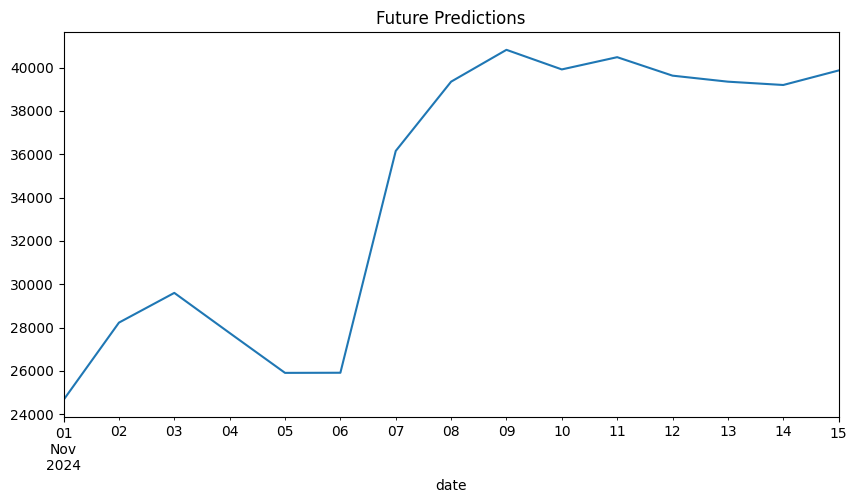

In [93]:
# Plot future predictions
future_w_features['pred'].plot(figsize=(10, 5),
                               title='Future Predictions')
plt.show()

## Add new sales data

In [ ]:
def add_sales_data(df):
    # Loop in case user inputs wrong date format
    while True:
        try:
            # Ask for date and convert to datetime
            date = input("Enter the date (YYYY-MM-DD): ")
            date = pd.to_datetime(date, format="%Y-%m-%d")  # Ensures correct format

            # Ask for sales amount and convert to float
            sales = float(input("Enter the sales amount: "))

            # Break loop if everything is valid
            break
        # Keep looping in case of error and show message
        except ValueError:
            print("Invalid input. Please enter the date in 'YYYY-MM-DD' format and a numeric sales value.")

    # Check if data is already in 'data' dataframe and update it if it is
    if date in df.index:
        print(f"\nDate {date.date()} already exists! Updating sales value from {df.loc[date, 'sales']} to {sales}.")
        # Modify existing value
        df.loc[date, 'sales'] = sales
    else:
        print(f"\nAdding new row for date {date.date()} with sales value {sales}")
        # Create new row as a DataFrame
        new_row = pd.DataFrame({"sales": [sales]}, index = [date])

        # Append the new row
        df = pd.concat([df, new_row])
        df = df.sort_index()
        df.index.name = 'date'

    # Pring last rows of updated dataframe
    print("\nUpdated DataFrame:")
    print(df.tail())

    return df

In [ ]:
# Call 'add_sales_data' to add new sale of the day
data = add_sales_data(data)

Enter the date (YYYY-MM-DD): 2025-02-12
Enter the sales amount: 40000

Adding new row for date 2025-02-12 with sales value 40000.0.

Updated DataFrame:
               sales  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
date                                                                       
2024-10-30  20590.85     24.7     11.6  18.6          24.7          11.6   
2024-10-31  26466.05     24.1     12.1  18.8          24.1          12.1   
2025-02-08  30000.00      NaN      NaN   NaN           NaN           NaN   
2025-02-11  35000.00      NaN      NaN   NaN           NaN           NaN   
2025-02-12  40000.00      NaN      NaN   NaN           NaN           NaN   

            precip  precipcover  is_rain  windgust  ...  is_holiday_3_lag  \
date                                                ...                     
2024-10-30     4.8         4.17      1.0      18.0  ...               0.0   
2024-10-31     0.0         0.00      1.0      19.8  ...               0.0   
2025-02